In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt
from scipy.stats import norm

In [2]:
pyro.enable_validation(True)

In [3]:
N = 10000
D = 10

In [4]:
def dgp(X):
#def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K = 7
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [5]:
trace = pyro.poutine.trace(dgp).get_trace(torch.zeros(N,D))
logp = trace.log_prob_sum()
true_variables = [trace.nodes[name]["value"] for name in trace.stochastic_nodes]
trace.stochastic_nodes

['D', 'loc', 'scale', 'K', 'cov_factor', 'N', 'obs']

In [6]:
logp

tensor(-261863.2500)

In [7]:
_,true_loc,true_scale,_,true_cov_factor,_,data = true_variables

In [8]:
K = 7
#initial_hyperparameters = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
initial_hyperparameters = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)

In [9]:
#def model(X):
def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [10]:
def guide(X, hyperparameters):
#def guide(X):
    #K = 2
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D, dim=-1):
        # get initial parameter values from parent
        # define parameters, clone initial parameter values from supplied hyperparameters, to avoid updating them
        loc_loc = pyro.param('loc_loc', locloc)
        loc_scale = pyro.param('loc_scale', locscale, constraint=constraints.positive)
        cov_diag_loc = pyro.param('scale_loc', scaleloc)
        cov_diag_scale = pyro.param('scale_scale', scalescale, constraint=constraints.positive)
        # sample variables
        loc = pyro.sample('loc', dst.Normal(loc_loc,loc_scale))
        with pyro.plate('K', K, dim=-2):
            cov_factor_loc = pyro.param('cov_factor_loc_{}'.format(K), cov_factor_loc)
            cov_factor_scale = pyro.param('cov_factor_scale_{}'.format(K), cov_factor_scale, constraint=constraints.positive)
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc, cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
        cov_diag = pyro.sample('scale', dst.LogNormal(cov_diag_loc, cov_diag_scale))
    return loc, cov_factor, cov_diag

In [11]:
track_params = True
def per_param_callable(module_name, param_name):
    #return {"lr": 0.01, "betas": (0.9, 0.8)} # too much momentum slows down learning apparently
    #return {"lr": 0.005, "betas": (0.9, 0.9)} # too much momentum slows down learning apparently
    return {"lr": 0.01, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    #return {"lr": 0.001, 'betas': [0.9, 0.99]}
    #return {"lr": 0.01, 'betas': [0.9, 0.99]}
    #return {"lr": 0.1, 'betas': [0.9, 0.99]}

In [12]:
pyro.clear_param_store()

In [13]:
conditioned_model = pyro.condition(model, data = {'obs': data})
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.99 })
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, scheduler, loss=elbo, num_samples=10)

In [14]:
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
# take one svi step to populate the param store
loss = svi.step(data, initial_hyperparameters)
#loss = svi.step(data, initial_hyperparameters)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [15]:
# if the dgp is contained within the model:
# check that the loss is small on true parameters, i.e. parameters where means are the true variables, and scales are 0.01

#params = pyro.get_param_store()
#scales = 0.0001
#true_params = (true_loc,scales*torch.ones_like(params.get_param('loc_scale')),\
#               true_scale,scales*torch.ones_like(params.get_param('scale_scale')),\
#              true_cov_factor,scales*torch.ones_like(params.get_param('cov_factor_scale_1')))
#for name,new_value in zip(params.get_all_param_names(),true_params):
#    params.replace_param(name,new_value,params.get_param(name))
#    
#print(true_params)
#print(svi.loss(conditioned_model, guide, data))

In [16]:
## check that the loss is big on random parameters
#params = pyro.get_param_store()
#true_params = (torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D)))
#for name,new_value in zip(params.get_all_param_names(),true_params):
#    params.replace_param(name,new_value,params.get_param(name))
#
#print(true_params)
#print(svi.loss(conditioned_model, guide, data, initial_hyperparameters))
## check loss on initial parameters
#params = pyro.get_param_store()
#true_params = (torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
#for name,new_value in zip(params.get_all_param_names(),true_params):
#    params.replace_param(name,new_value,params.get_param(name))
#    
#print(true_params)
#print(svi.loss(conditioned_model, guide, data, initial_hyperparameters))

In [17]:
# optimize
#for i in range(20000):
i = 0
window = 300
gradients_are_decreasing = [True]
while i < 20000 and any(gradients_are_decreasing):
    loss = svi.step(data, initial_hyperparameters)
    if i % window or i <= window:
        print('.', end='')
    else:
        scheduler.step()
        state = scheduler.get_state()['loc_loc']
        print('\nSetting lr to {}'.format(state['base_lrs'][0]*state['gamma']**state['last_epoch']), end='')
        print('\n', end='')
        # check if gradients are trending downwards
        gradients_are_decreasing = []
        for name, gradient_norm in gradient_norms.items():
            recent = gradient_norm[-window:]
            # estimate slope by least squares
            m_hat = np.linalg.lstsq(np.vstack([np.arange(window), np.ones(window)]).T,recent, rcond=None)[0][0]
            # estimate standard deviation of losses in window
            s_hat = np.array(recent).std(ddof=2)
            # calculate probability that slope is less than 0
            P_negative_slope = norm.cdf(0,loc=m_hat,scale=12*s_hat**2/(window**3-window))
            # if it is more than .5, loss has been decreasing
            gradients_are_decreasing.append(P_negative_slope > .5)
    #loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        #print('.' if i % 100 else '\n', end='')
    i += 1
params = pyro.get_param_store()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Setting lr to 0.0099
...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.009801
.......................................................

...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.007856781408072187
...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.007778213593991467
...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.00770043145805

...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.00617290140942288
...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.00611117239532865
...........................................................................................................................................................................................................................................................................................................
Setting lr to 0.0060500606713753

In [19]:
i

18901

In [20]:
list(pyro.get_param_store().items())

[('loc_loc',
  tensor([-0.8190, -0.3381, -1.4654, -1.5913, -0.2902, -2.6060,  1.5602, -0.4501,
           0.8683, -0.3901], requires_grad=True)),
 ('loc_scale',
  tensor([0.0220, 0.0360, 0.0196, 0.0115, 0.0325, 0.0439, 0.0397, 0.0293, 0.0153,
          0.0149], grad_fn=<AddBackward0>)),
 ('scale_loc',
  tensor([-4.7195,  2.3751,  0.9212, -0.8948,  2.3009,  2.9811, -7.7856,  0.5807,
          -0.0182,  0.4189], requires_grad=True)),
 ('scale_scale',
  tensor([1.0051, 0.0182, 0.0204, 0.0422, 0.0170, 0.0146, 0.1018, 0.0701, 0.0356,
          0.0198], grad_fn=<AddBackward0>)),
 ('cov_factor_loc_7',
  tensor([[-1.2952,  1.2514, -1.8922, -0.3515,  0.6112, -0.1516, -4.0347,  2.9436,
            1.1681, -1.5348],
          [-0.8363, -0.6915, -1.1276,  0.3680,  1.3383,  0.1692,  5.5582, -0.3935,
            0.0176,  0.1227],
          [-0.3024,  0.1217, -0.0659, -0.2102,  0.0634, -0.2121, -0.8846,  0.0611,
           -0.0994, -0.1011],
          [-0.6042,  2.2229, -0.1298, -0.2404, -1.6619, -1.

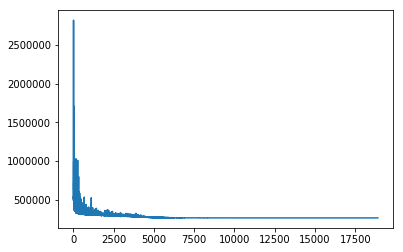

In [21]:
plt.plot(losses)

In [22]:
gradient_norms.keys()

dict_keys(['scale_loc', 'cov_factor_loc_7', 'cov_factor_scale_7', 'loc_loc', 'scale_scale', 'loc_scale'])

In [23]:
gradient_norms.keys()

dict_keys(['scale_loc', 'cov_factor_loc_7', 'cov_factor_scale_7', 'loc_loc', 'scale_scale', 'loc_scale'])

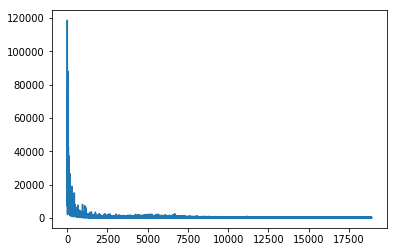

In [24]:
plt.plot(gradient_norms['loc_loc'])

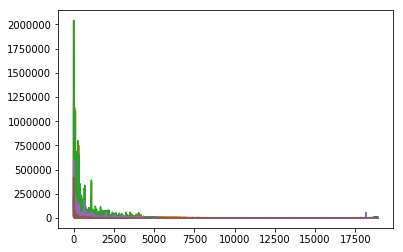

In [25]:
plt.plot(np.array(list(gradient_norms.values())).T)

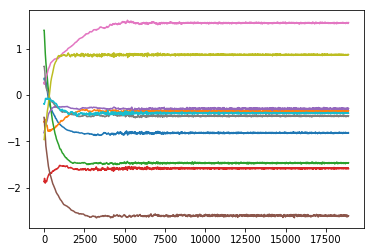

In [26]:
plt.plot(param_history['loc_loc'].detach().numpy())

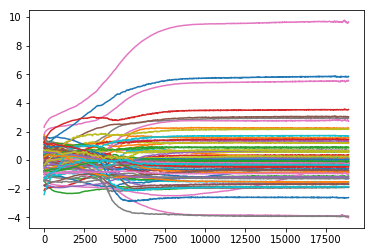

In [27]:
plt.plot(param_history['cov_factor_loc_7'].reshape(-1,K*D).detach().numpy());

In [28]:
# MAP
est_cov_factor = pyro.param('cov_factor_loc_{}'.format(K))
est_diag = dst.LogNormal(params.get_param('scale_loc'),params.get_param('scale_scale')).mean

In [29]:
# EXPECTED COVARIANCE AND CORRELATION
#true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
print(true_total_cov)
invsds = torch.diag(torch.sqrt(torch.diag(true_total_cov))).inverse()
# expected correlation matrix
torch.matmul(invsds,torch.matmul(true_total_cov,invsds))

tensor([[ 4.4958e+01, -1.5402e+01,  6.4320e+00,  1.7070e+01, -4.6993e+00,
          2.4555e+01,  5.0720e+01,  6.0312e+00,  9.4316e+00,  1.7159e+01],
        [-1.5402e+01,  2.2893e+01, -1.9482e+00, -3.8663e+00, -4.4604e+00,
         -1.1461e+01, -1.8848e+01, -4.6508e+00, -8.0751e-01, -6.0467e+00],
        [ 6.4320e+00, -1.9482e+00,  8.9480e+00,  4.7090e+00, -4.6930e+00,
          1.3308e+00,  1.2910e+01, -8.6325e+00,  1.3028e-01,  2.6757e+00],
        [ 1.7070e+01, -3.8663e+00,  4.7090e+00,  1.5513e+01, -5.7434e+00,
          8.8746e+00,  4.2601e+01, -7.3980e+00,  7.6112e+00,  3.9503e+00],
        [-4.6993e+00, -4.4604e+00, -4.6930e+00, -5.7434e+00,  1.8602e+01,
          9.1752e-01, -1.0922e+01,  8.9795e+00, -2.5391e+00, -1.7947e+00],
        [ 2.4555e+01, -1.1461e+01,  1.3308e+00,  8.8746e+00,  9.1752e-01,
          3.6735e+01,  2.7234e+01,  1.0233e+01,  4.3827e+00,  8.6555e+00],
        [ 5.0720e+01, -1.8848e+01,  1.2910e+01,  4.2601e+01, -1.0922e+01,
          2.7234e+01,  1.5238e+0

tensor([[ 1.0000, -0.4801,  0.3207,  0.6464, -0.1625,  0.6042,  0.6128,  0.1579,
          0.5023,  0.7666],
        [-0.4801,  1.0000, -0.1361, -0.2052, -0.2161, -0.3952, -0.3191, -0.1707,
         -0.0603, -0.3786],
        [ 0.3207, -0.1361,  1.0000,  0.3997, -0.3638,  0.0734,  0.3496, -0.5067,
          0.0156,  0.2679],
        [ 0.6464, -0.2052,  0.3997,  1.0000, -0.3381,  0.3718,  0.8762, -0.3298,
          0.6900,  0.3004],
        [-0.1625, -0.2161, -0.3638, -0.3381,  1.0000,  0.0351, -0.2051,  0.3656,
         -0.2102, -0.1246],
        [ 0.6042, -0.3952,  0.0734,  0.3718,  0.0351,  1.0000,  0.3640,  0.2964,
          0.2582,  0.4278],
        [ 0.6128, -0.3191,  0.3496,  0.8762, -0.2051,  0.3640,  1.0000, -0.4040,
          0.4923,  0.4594],
        [ 0.1579, -0.1707, -0.5067, -0.3298,  0.3656,  0.2964, -0.4040,  1.0000,
         -0.0654,  0.0866],
        [ 0.5023, -0.0603,  0.0156,  0.6900, -0.2102,  0.2582,  0.4923, -0.0654,
          1.0000,  0.0802],
        [ 0.7666, -

In [30]:
# EMPIRICAL COVARIANCE AND CORRELATION
print(np.cov(data.detach().numpy().T))
#empirical correlation matrix
np.corrcoef(data.detach().numpy().T)

[[ 4.37858999e+01 -1.53548659e+01  6.44482750e+00  1.70724372e+01
  -4.54693588e+00  2.37326656e+01  4.96359940e+01  5.58602801e+00
   9.50417065e+00  1.62847387e+01]
 [-1.53548659e+01  2.30180784e+01 -1.82260748e+00 -3.93905905e+00
  -4.59325601e+00 -1.10293832e+01 -1.88796042e+01 -4.73750843e+00
  -9.47672530e-01 -5.89946877e+00]
 [ 6.44482750e+00 -1.82260748e+00  8.95729573e+00  4.71049143e+00
  -4.62105867e+00  1.48850021e+00  1.23703061e+01 -8.48041817e+00
   1.28151751e-01  2.59440604e+00]
 [ 1.70724372e+01 -3.93905905e+00  4.71049143e+00  1.54593539e+01
  -5.63972489e+00  8.88893202e+00  4.18439653e+01 -7.16174087e+00
   7.69453806e+00  3.87031822e+00]
 [-4.54693588e+00 -4.59325601e+00 -4.62105867e+00 -5.63972489e+00
   1.84175562e+01  9.07746309e-01 -1.02286294e+01  8.93960342e+00
  -2.55273692e+00 -1.64114702e+00]
 [ 2.37326656e+01 -1.10293832e+01  1.48850021e+00  8.88893202e+00
   9.07746309e-01  3.57021252e+01  2.68351712e+01  9.66227719e+00
   4.42094179e+00  8.11067531e+00

array([[ 1.        , -0.48366466,  0.32542859,  0.65619469, -0.16011635,
         0.60025025,  0.61594898,  0.15027326,  0.51116708,  0.75501368],
       [-0.48366466,  1.        , -0.12693172, -0.20881529, -0.22308487,
        -0.38474206, -0.32312719, -0.17577666, -0.07029745, -0.37724157],
       [ 0.32542859, -0.12693172,  1.        ,  0.40029678, -0.35978001,
         0.08323642,  0.33939633, -0.5043994 ,  0.01523884,  0.26594428],
       [ 0.65619469, -0.20881529,  0.40029678,  1.        , -0.33423063,
         0.37836145,  0.87388105, -0.32424156,  0.69647042,  0.30198973],
       [-0.16011635, -0.22308487, -0.35978001, -0.33423063,  1.        ,
         0.03539985, -0.19571161,  0.37080706, -0.21169268, -0.11732016],
       [ 0.60025025, -0.38474206,  0.08323642,  0.37836145,  0.03539985,
         1.        ,  0.36878436,  0.28785794,  0.26331982,  0.41643876],
       [ 0.61594898, -0.32312719,  0.33939633,  0.87388105, -0.19571161,
         0.36878436,  1.        , -0.39617575

In [31]:
# MAP COVARIANCE AND CORRELATION
est_total_cov = est_cov_factor.transpose(0,1) @ est_cov_factor + torch.diag(est_diag)
print(est_total_cov)
est_invsds = torch.diag(torch.sqrt(torch.diag(est_total_cov))).inverse()
est_corr_mat = torch.matmul(est_invsds,torch.matmul(est_total_cov,est_invsds))
print(est_corr_mat)

tensor([[ 4.3914e+01, -1.5473e+01,  6.4243e+00,  1.7210e+01, -4.5124e+00,
          2.3665e+01,  5.0290e+01,  5.4726e+00,  9.5517e+00,  1.6356e+01],
        [-1.5473e+01,  2.3212e+01, -1.8314e+00, -4.0080e+00, -4.5547e+00,
         -1.1033e+01, -1.9204e+01, -4.6846e+00, -9.9757e-01, -6.0039e+00],
        [ 6.4243e+00, -1.8314e+00,  8.9374e+00,  4.7235e+00, -4.6320e+00,
          1.4563e+00,  1.2497e+01, -8.5730e+00,  1.1144e-01,  2.6072e+00],
        [ 1.7210e+01, -4.0080e+00,  4.7235e+00,  1.5530e+01, -5.6009e+00,
          8.8861e+00,  4.2187e+01, -7.2606e+00,  7.6884e+00,  3.8998e+00],
        [-4.5124e+00, -4.5547e+00, -4.6320e+00, -5.6009e+00,  1.8306e+01,
          1.2300e+00, -1.0121e+01,  8.9538e+00, -2.4741e+00, -1.5883e+00],
        [ 2.3665e+01, -1.1033e+01,  1.4563e+00,  8.8861e+00,  1.2300e+00,
          3.5790e+01,  2.6878e+01,  9.6710e+00,  4.4318e+00,  8.1344e+00],
        [ 5.0290e+01, -1.9204e+01,  1.2497e+01,  4.2187e+01, -1.0121e+01,
          2.6878e+01,  1.4970e+0

In [32]:
from hinton import *

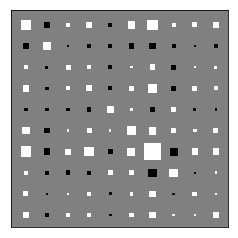

In [33]:
hinton(true_total_cov)

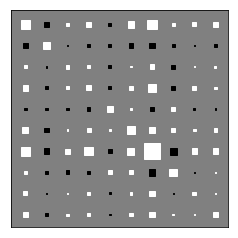

In [34]:
hinton(est_total_cov.detach().numpy())

In [35]:
from tracepredictive import *

trace_pred = TracePredictive(model, svi, num_samples=1000).run(data[:,:500], initial_hyperparameters)
random_idx = np.random.randint(1000)
predictive_dst_sample = [torch.unsqueeze(trace.nodes['obs']['value'][random_idx,:],dim=0) for trace in trace_pred.exec_traces]
predictive_dst_sample = torch.cat(predictive_dst_sample, dim=0)

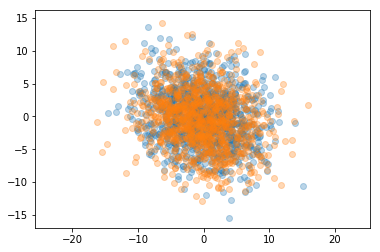

In [42]:
random_dims = np.random.choice(data.shape[1], size=2, replace=False)
random_dims.sort()
plt.scatter(*data.detach().numpy().T[random_dims,:1000],alpha=.3)
#plt.axis('equal');
#plt.figure()
plt.scatter(*predictive_dst_sample.detach().numpy().T[random_dims],alpha=.3);
plt.axis('equal');

In [37]:
true_cov_factor.transpose(0,1)

tensor([[-1.5789e+00, -6.3836e-01,  1.8868e+00,  4.1286e+00, -3.8082e+00,
          1.2209e+00,  2.0759e+00],
        [ 8.6737e-01,  1.5170e+00, -2.0718e+00, -2.0289e+00, -1.3038e-01,
          2.6727e-01, -7.7151e-01],
        [ 6.1377e-02,  9.3662e-01,  1.3907e+00,  7.6008e-01, -1.1396e+00,
         -3.5093e-01, -1.2268e+00],
        [ 6.5159e-01,  9.8844e-01, -3.1120e-01,  3.0635e+00, -1.8105e+00,
         -9.4306e-01,  4.4573e-01],
        [-1.3221e+00, -1.7449e+00, -1.2609e-01,  1.2784e-01,  2.2466e+00,
         -3.3281e-01,  3.7155e-01],
        [-1.0216e+00, -4.5864e-01,  1.4259e+00,  2.5540e+00, -9.8619e-01,
          3.2170e-01,  2.5369e+00],
        [ 3.9924e+00,  3.4205e-01,  2.3019e-01,  1.1218e+01, -2.8838e+00,
         -2.0756e-01, -1.1331e-01],
        [-2.8771e+00, -8.9731e-01,  9.8443e-04, -1.1271e+00,  1.1370e+00,
          1.0369e+00,  4.1576e+00],
        [ 1.4072e-01, -4.9815e-01, -1.2046e+00,  1.0304e+00, -1.8180e+00,
         -9.0950e-01,  7.4246e-01],
        [-

In [38]:
est_cov_factor

tensor([[-1.2952,  1.2514, -1.8922, -0.3515,  0.6112, -0.1516, -4.0347,  2.9436,
          1.1681, -1.5348],
        [-0.8363, -0.6915, -1.1276,  0.3680,  1.3383,  0.1692,  5.5582, -0.3935,
          0.0176,  0.1227],
        [-0.3024,  0.1217, -0.0659, -0.2102,  0.0634, -0.2121, -0.8846,  0.0611,
         -0.0994, -0.1011],
        [-0.6042,  2.2229, -0.1298, -0.2404, -1.6619, -1.6966, -0.2172, -1.8950,
          0.2479,  0.5639],
        [-2.6240,  1.5601,  0.8671,  1.4376, -1.2453, -1.8653,  2.7241, -3.9330,
          0.5630, -1.8703],
        [ 5.8463, -1.5292,  0.8910,  3.5296, -1.1747,  3.0175,  9.6609, -0.4215,
          2.1660,  1.6899],
        [ 0.0203, -0.8279, -0.0761, -0.4845,  0.6779, -0.7198, -0.9697, -1.2752,
          0.6672, -0.3170]], requires_grad=True)